# Colocalization

Colocalization refers to two distinct measures: co-occurance and correlation [https://jcs.biologists.org/content/131/3/jcs211847].




## Co-occurance

In this context, we tried to evaluate the overlap of the set of pixels between two images.

We start by creating a pair of test images. The images are composed of circles of which a fraction is overlapping.


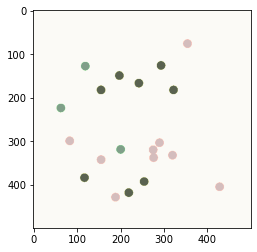

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

def create_overlapping_circles(shape,m,r0,rho):
    ''' Create a test image pair with random circles 
    Parameter
    ---------
    shape : image size
    m : total number of circle
    r0 : radius of circles
    rho : proportion of overlapping circle
    Result
    ------
    I1,I2 two images with overlapping circles
    '''
    np.random.seed()
    x,y = np.meshgrid(range(shape[1]), range(shape[0]))
    p = 0.1+0.8*np.random.rand(3,m)
    S = np.array([[shape[1],0,0],[0,shape[0],0],[0,0,0]])
    p = np.matmul(S,p)
    p[2,:] = p[2,:] + r0
    I1 = np.zeros(shape)
    I2 = np.zeros(shape)
    n1 = 0
    n2 = 0
    n12 = 0
    for i in range(m):
        v = np.random.rand()
        D = ((x - p[0,i]) / p[2,i])**2 + ((y-p[1,i]) / p[2,i])**2 < 1
        if v < 0.5 + rho/2:
            I1 = np.logical_or(I1 , D)
            n1 = n1 + 1
        if  v > 0.5 - rho/2:
            I2 = np.logical_or(I2 , D)
            n2 = n2 + 1
        if v >0.5 - rho/2 and v < 0.5 + rho/2:
            n12 = n12 + 1
    return I1,I2 
    
im1,im2 = create_overlapping_circles((500,500),20,10,0.5)

plt.imshow(im1,cmap='Reds',alpha=0.5)
plt.imshow(im2,cmap='Greens',alpha=0.5)

Let's define another way to visualize the image pair:

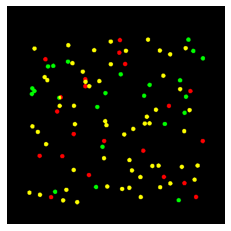

In [38]:
def to_rgb(im1,im2):
    ''' Convert the a2 channel image to a xyc rgb normlized image'''
    rgb = np.zeros((im1.shape[0], im1.shape[1], 3))
    rgb[:,:,0] = im1
    rgb[:,:,1] = im2
    if im1.dtype == 'float':
        a = min(np.min(im1), np.min(im2))
        b = max(np.max(im1), np.max(im2))
        return (rgb - a) / (b-a)
    else :
        return rgb

# Another way to display the image pair:
plt.imshow(to_rgb(im1,im2))
plt.axis('off')
plt.show()

### Manders coefficients

To evaluate co-occurance we compute the Manders coefficients defined by the ratios M1 = (A . B) / (A) and M2 = (A . B) / B. The regions A and B will be defined by segmenting each channels.

Manders, E., Verbeek, F. and Aten, J. (1993) Measurement of co‐localization of objects in dual‐colour confocal images. Journal of Microscopy, 169, Pt 3, 375–382. 

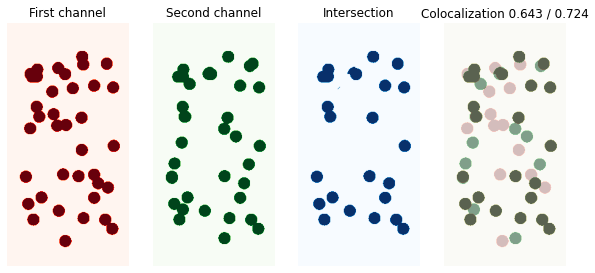

In [39]:
# Let's define a function for computing the Manders coefficients
def manders_coefficients(im1,im2,display=False):
    ''' Compute Manders overlap coefficients'''
    intersect = np.logical_and(im1,im2)
    p12 = np.sum(intersect>0)
    p1 = np.sum(im1>0)
    p2 = np.sum(im2>0)
    if display:
        fig, ax = plt.subplots(1, 4,figsize=(10,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'Colocalization {p12/p1:.3f} / {p12/p2:.3f}')
        for a in ax:
            a.set_axis_off()
    return ( p12 / p1, p12 / p2)

im1,im2 = create_overlapping_circles((400,200),50,10,0.5)
M1,M2 = manders_coefficients(im1,im2,True)


0.633098305482351


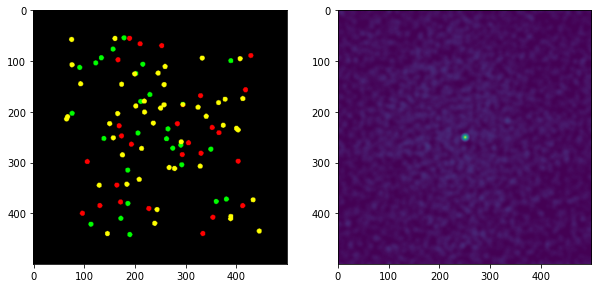

In [42]:
def normxcorr(template,image):
    '''
        Normalized cross correlation
    '''
    from math import sqrt
    template = template - np.mean(template)
    image = image - np.mean(image)
    F = np.fft.fftn(image)
    T = np.fft.fftn(template)
    out = np.real(np.fft.ifftn(F * np.conj(T)))
    F2 = np.fft.fftn(np.square(image))
    A1 = np.fft.fftn(np.ones(template.shape))
    image = np.real(np.fft.fftn(F2*A1)) - np.square(np.real(np.fft.fftn(F*A1)))/np.prod(template.shape)
    image[np.where(image < 0)] = 0
    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    return np.fft.fftshift(out) * sqrt(np.prod(image.shape))

im1,im2 = create_overlapping_circles((500,500), 100, 5, .5)
#im1 = im1 + 0.1*np.random.random_sample(im1.shape)
#im2 = im2 + 0.1*np.random.random_sample(im2.shape)
#im2 = np.roll(im2,10)
C = normxcorr(im1,im2)
fig, ax = plt.subplots(1, 2,figsize=(10,7))
ax[0].imshow(to_rgb(im1,im2))
ax[1].imshow(C)
#ax[1].addcolorbar()
print(np.max(C))



## GcoPS

Two binary images can be seen as two random sets for which we would like to test the independance from a probabilitic point of view.
This idea, proposed in  https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115, is to test the independance of the probability of belonging to each set $p_1$ and $p_2$ and to belong to both sets $p_{12}$ by looking at the value of $D=p_{12}- p_1p_2$ normalized by the autocorrelation $C_1$ and $C_2$ of the two set:
$$T  = \sqrt{|R|} \frac{p_{12} - p_1 p_2}{\sqrt{\sum_R C_1 C_2}} $$

The $T$ statistic is assumed to be normally distributed which allow to compute a p-value. We can interpret this p-value as if the set are colocalized it is due to an actual overlap and not randomness. 




0.23109374847263098
0.23109375


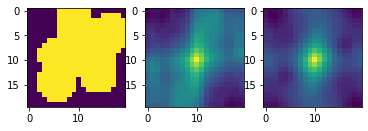

In [335]:
def autocorrelation(im):
    im = im - np.mean(im)
    shp = (im.shape[0],im.shape[1])
    C = np.zeros(shp)
    N = np.zeros(shp)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            for k in range(im.shape[0]):
                for l in range(im.shape[1]):
                        h1 = k-i+im.shape[0]//2
                        h2 = l-j+im.shape[0]//2
                        if h1 >=0 and h2 >= 0 and h1 < shp[0] and h2 < shp[1]:
                            C[h1,h2] += (im[i,j] * im[k,l])
                            N[h1,h2] += 1
    I = np.where(N>0)
    C[I] = C[I] / N[I]
    return C

def autocorrelation_fft(im):
     im = im - np.mean(im)
     n = np.prod(im.shape)
     return  np.real(np.fft.ifftn(np.abs(np.fft.fftn(im))**2)) / n

im1,im2 = create_overlapping_circles((20,20),10,4, 0.5)
C1 = variogram(im1.astype('f'))
C2 = np.fft.fftshift(variogram_fft(im1))
fig,ax = plt.subplots(1,3)
ax[0].imshow(im1)
ax[1].imshow(C1)
ax[2].imshow(C2)
print(np.max(C1))
print(np.max(C2))

Manders M1:0.066, M2:0.064
GCoPS D:0.001, T:1.904, pvalue:0.028 The two sets are not independant
<ipython-input-318-8080826e36b2>:59: RuntimeWarning: divide by zero encountered in log
  ax[4].imshow(np.log(np.fft.fftshift(R*C1*C2)))


('The two sets are not independant', 0.028461989085266204, 1.9038940961757163)

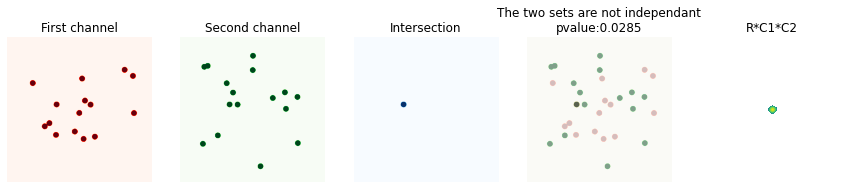

In [318]:
def GcoPS(im1,im2,alpha=0.05,display=False):
    ''' Test the colocalization of two random set 

    Parameter
    ---------
    im1 : numpy array
    im2 : numpy array
    alpha : level of confidence for the pvalue

    Result
    ------
    msg: the hypothesis
    pvalue : the p-value of the test
    T: the T statistic
    Reference
    ---------
    [1] https://onlinelibrary.wiley.com/doi/full/10.1111/biom.13115
    '''
    from scipy.stats import norm
    from math import sqrt
    # get the imaeg size
    ny = im1.shape[0]
    nx = im1.shape[1]
    n = nx * ny
    # compute the intersection of the two sets
    intersect = np.logical_and(im1,im2)
    # compute the estimates p1 p2
    p1 = np.mean(im1)
    p2 = np.mean(im2)
    p12 = np.mean(intersect)
    D = p12 - p1 * p2
    # compute the autocorrelation of the two images
    C1 = np.real(np.fft.ifftn(np.abs(np.fft.fftn(im1-p1))**2)) / n
    C2 = np.real(np.fft.ifftn(np.abs(np.fft.fftn(im2-p2))**2)) / n
    # Compute a valid region R where the correlation is above the noise floor 
    R = np.logical_and(C1 > np.std(C1), C2 > np.std(C2)).astype('f')
    S = np.sum(R * C1 * C2)
    # Test statistics
    T = D / sqrt(S/n)
    # Deduce the pvalue (T is normaly distributed)
    pvalue = 1-norm.cdf(T)
    # Set the hypothesis message
    if pvalue < alpha:
        msg = 'The two sets are not independant'
    else:
        msg = 'The two sets are independant'
    # Display colocalization information
    if display:
        fig, ax = plt.subplots(1, 5,figsize=(15,7))
        ax[0].imshow(im1,cmap='Reds')
        ax[0].set_title('First channel')
        ax[1].imshow(im2,cmap='Greens')
        ax[1].set_title('Second channel')
        ax[2].imshow(intersect,cmap='Blues')
        ax[2].set_title('Intersection')
        ax[3].imshow(im1,cmap='Reds',alpha=0.5)
        ax[3].imshow(im2,cmap='Greens',alpha=0.5)
        ax[3].set_title(f'{msg}\npvalue:{pvalue:.3g}')
        ax[4].imshow(np.log(np.fft.fftshift(R*C1*C2)))
        ax[4].set_title('R*C1*C2')
        for a in ax:
            a.set_axis_off()
        print(f'Manders M1:{p12/p1:.3f}, M2:{p12/p2:.3f}')
        print(f'GCoPS D:{D:.3f}, T:{T:.3f}, pvalue:{pvalue:.3f} {msg}')
    return msg, pvalue, T

im1,im2 = create_overlapping_circles((500,500),30,10, 0.01)
GcoPS(im1, im2, 0.05, True) 


1.1353265854569277 0.26020409063031086


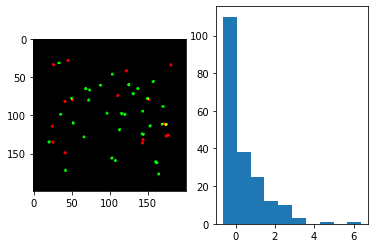

In [319]:
n = 200
T = np.zeros((n,1))
for i in range(n):
    im1, im2 = create_overlapping_circles((200,200), 50, 2, 0)
    T[i] = GcoPS(im1, im2, 0.05)[2]
fig,ax = plt.subplots(1,2)
ax[0].imshow(to_rgb(im1,im2))
ax[1].hist(T)
print(np.std(T),np.mean(T))

Test the procedure for various level of colocalization

0.0


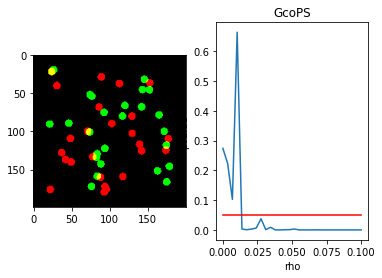

In [322]:
n = 30
p = np.zeros((n,1))
rho = np.linspace(0,.1,n)
for i,r in enumerate(rho):
    im1,im2 = create_overlapping_circles((200,200),100,5, r)
    p[i] = GcoPS(im1, im2, 0.05)[1]

im1, im2 = create_overlapping_circles((200,200),50,5, rho[15])
fig, ax = plt.subplots(1,2)
ax[0].imshow(to_rgb(im1,im2))
ax[1].plot(rho,p)
ax[1].plot(rho, 0.05*np.ones(rho.shape),'r')
ax[1].set_xlabel('rho')
ax[1].set_ylabel('pvalue')
ax[1].set_title('GcoPS')
print(np.min(p))

<ipython-input-318-8080826e36b2>:59: RuntimeWarning: divide by zero encountered in log
  ax[4].imshow(np.log(np.fft.fftshift(R*C1*C2)))
Manders M1:0.037, M2:0.034
GCoPS D:0.000, T:0.686, pvalue:0.246 The two sets are independant
Manders M1:0.065, M2:0.064
GCoPS D:0.001, T:3.685, pvalue:0.000 The two sets are not independant


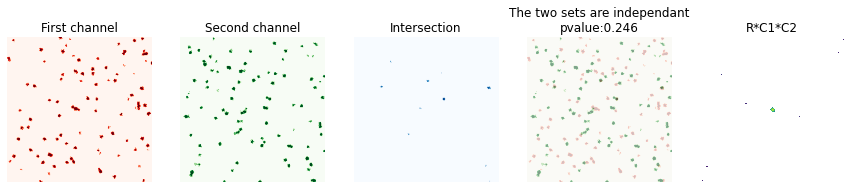

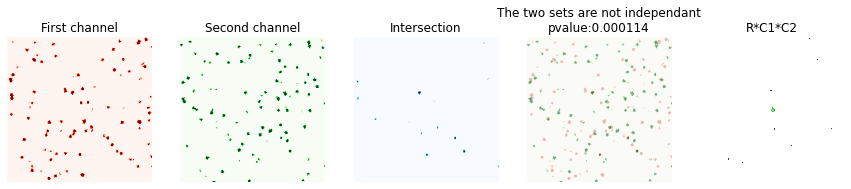

In [323]:
# Here is a example using the same data than the one on the GCOPS's website for reference 

# non colocalized example
im1a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho0.png')
im1b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho0.png')
msg1, pvalue1,t1 = GcoPS(im1a, im1b, 0.05, True) 

# colocalized example
im2a = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift1_rho05.png')
im2b = plt.imread('https://team.inria.fr/serpico/files/2020/08/nonoise_noshift2_rho05.png')
msg2, pvalue2,t2 = GcoPS(im2a, im2b, 0.05, True) 



## Correlation

The correlation can be estimated using the Pearson correlation coefficient PCC


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

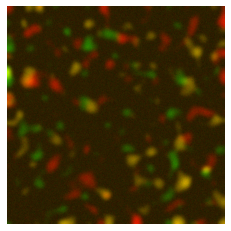

In [306]:
import numpy as np
from skimage import filters

def create_correlated_images(shape:int, radius:float, p:float, noise_level):
    '''   Create a pair of correlated images

    Parameters
    ----------
    shape : image size
    radius : standard deviation of the Gaussian blur
    p : Amount of correlation  [0,1]
    noise_level : amount of noise (factor of the std)
    Returns
    -------
    two numpy arrays
    '''
    im = list()
    for i in range(3):
        im.append(np.random.normal(0,10,size=shape))
        im[i] = filters.gaussian(im[i], radius, mode='reflect')
        im[i] = im[i] - np.std(im[i])
        im[i][np.where(im[i]<0)] = 0
        if i > 0 :
            im[i] = p * im[0] + (1-p) * im[i]
            im[i] = filters.gaussian(im[i], radius/3, mode='reflect')
            if noise_level > 0:
                im[i] = im[i] + np.random.normal(0,noise_level*np.std(im[i]),size=shape)
            a,b = np.min(im[i]), np.max(im[i])
            im[i] = 100 + 500 * (im[i] - a) / (b-a)

    return im[1], im[2]

im1,im2 = create_correlated_images((512,512),10,0.5,0.4)
plt.imshow(to_rgb(im1,im2))
plt.axis('off')


In [311]:
from skimage import filters

def coloc_histogram(im1, im2, height=200, width=200):
    '''  2D Colocalization histogram

    Parameter
    ---------
    im1 : first channel (numpy array) 
    im2 : second channel (numpy array) 
    height: int (optional), the height of the buffer
    width:  int (optional), the width of the buffer
    Result
    ------
    ax_extent: the extents of the axis
    buffer : the histogram
    [1] https://stackoverflow.com/questions/42639129/is-matplotlib-scatter-plot-slow-for-large-number-of-data
    '''
    im1 = np.ravel(im1)
    im2 = np.ravel(im2)
    xlims = (im1.min(), im1.max())
    ylims = (im2.min(), im2.max())
    dxl = xlims[1] - xlims[0]
    dyl = ylims[1] - ylims[0]
    buffer = np.zeros((height+1, width+1))
    n = np.prod(im1.shape)
    for i in range(n):
        x0 = int(round(((im1[i]- xlims[0]) / dxl) * width))
        y0 = int(round((1 - (im2[i] - ylims[0]) / dyl) * height))
        buffer[y0, x0] += 1
    ax_extent = list(xlims)+list(ylims)
    return ax_extent, buffer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Image 2')

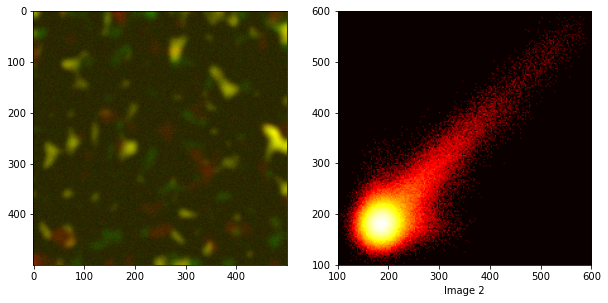

In [314]:
im1,im2 = create_correlated_images((500,500),10,0.75,0.5)
ax_extent,h = coloc_histogram(im1,im2)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(to_rgb(im1,im2))
ax[1].imshow(np.log(1+h), cmap='hot', extent=ax_extent)
ax[1].set_xlabel('Image 1')
ax[1].set_xlabel('Image 2')

In [315]:
import scipy 
# compute the pearson correlation coefficient
[r,pvalue] = scipy.stats.pearsonr(im1.ravel(), im2.ravel())
print(f'Pearson correlation:{r:.2f} pvalue {pvalue:0.3g}')

Pearson correlation:0.72 pvalue 0


In [316]:
[r,pvalue] = scipy.stats.spearmanr(im1.ravel(), im2.ravel())
print(f'Spearman correlation:{r:.2f} pvalue {pvalue:0.3g}')

Spearman correlation:0.29 pvalue 0


## Point cloud colocalization